In [1]:
from typing import Callable, Any, Optional, List
from einops import rearrange

import torch
import torch.nn as nn

## Implementation MobileViT
1. Transformer Module
2. MobileViT Block
3. MobileViT Overall Model 

### 1. Transformer Module
![Transformer Encoder.png](<attachment:Transformer Encoder.png>)
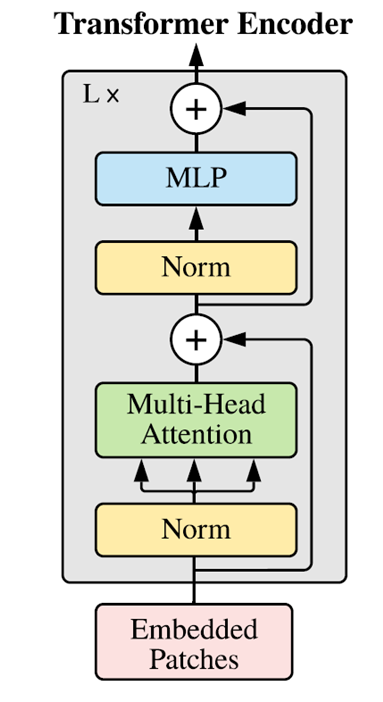

In [2]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

In [3]:
class MultiHeadSelfAttention(nn.Module):
    """
    dim:
        Token's dimension, EX: word embedding vector size
    num_heads:
        The number of distinct representations to learn
    dim_head:
        The dimension of the each head
    """
    def __init__(self, dim, num_heads = 8, dim_head = None):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.dim_head = int(dim / num_heads) if dim_head is None else dim_head
        _weight_dim = self.num_heads * self.dim_head
        self.to_qvk = nn.Linear(dim, _weight_dim * 3, bias = False)
        self.scale_factor = dim ** -0.5

        self.scale_factor = dim ** -0.5

        # Weight matrix for output, Size: num_heads*dim_head X dim
        # Final linear transformation layer
        self.w_out = nn.Linear(_weight_dim, dim, bias = False)

    def forward(self, x):
        qkv = self.to_qvk(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b p n (h d) -> b p h n d', h = self.num_heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale_factor
        attn = torch.softmax(dots, dim = -1)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b p h n d -> b p n (h d)')
        return self.w_out(out)


In [4]:
# FeedForwardBlock
class FFN(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

In [5]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.1):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, MultiHeadSelfAttention(dim, heads, dim_head)),
                PreNorm(dim, FFN(dim, mlp_dim, dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

### 2. MobileViT Block
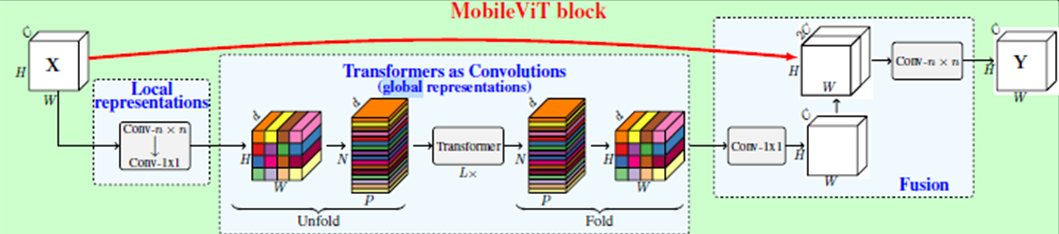

In [6]:
class ConvNormAct(nn.Module):
    def __init__(self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        stride = 1,
        padding: Optional[int] = None,
        groups: int = 1,
        norm_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.BatchNorm2d,
        activation_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.SiLU,
        dilation: int = 1
    ):
        super(ConvNormAct, self).__init__()
        if padding is None:
            padding = (kernel_size - 1) // 2 * dilation
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding,
                                    dilation = dilation, groups = groups, bias = norm_layer is None)

        self.norm_layer = nn.BatchNorm2d(out_channels) if norm_layer is None else norm_layer(out_channels)
        self.act = activation_layer() if activation_layer is not None else activation_layer

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        if self.norm_layer is not None:
            x = self.norm_layer(x)
        if self.act is not None:
            x = self.act(x)
        return x

In [7]:
class MobileVitBlock(nn.Module):
    def __init__(self, in_channels, out_channels, d_model, layers, mlp_dim):
        super(MobileVitBlock, self).__init__()
        # Local representation
        self.local_representation = nn.Sequential(
            # Encode local spatial information
            ConvNormAct(in_channels, in_channels, 3),
            # Projects the tensor to a high-diementional space
            ConvNormAct(in_channels, d_model, 1)
        )
        # Transformer as Convolutions (global representations)
        self.transformer = Transformer(d_model, layers, 1, 32, mlp_dim, 0.1)

        # Fusion block
        self.fusion_block1 = nn.Conv2d(d_model, in_channels, kernel_size = 1)
        self.fusion_block2 = nn.Conv2d(in_channels * 2, out_channels, 3, padding = 1)

    def forward(self, x):
        local_repr = self.local_representation(x)
        # global_repr = self.global_representation(local_repr)
        _, _, h, w = local_repr.shape
        # ph, pw 설정
        ph, pw = 2, 2
        if h % ph != 0 or w % pw != 0:
            # 만약 h, w가 2로 나누어지지 않으면 ph, pw 값을 1로 설정
            ph, pw = 1, 1

        # Reshape the tensor for the transformer
        global_repr = rearrange(local_repr, 'b d (h ph) (w pw) -> b (ph pw) (h w) d', ph=ph, pw=pw)
        
        # Pass through transformer
        global_repr = self.transformer(global_repr)
        
        # Reshape back to original form
        global_repr = rearrange(global_repr, 'b (ph pw) (h w) d -> b d (h ph) (w pw)', h=h//ph, w=w//pw, ph=ph, pw=pw)
        
        # Fuse the local and gloval features in the concatenation tensor
        fuse_repr = self.fusion_block1(global_repr)
        result = self.fusion_block2(torch.cat([x, fuse_repr], dim = 1))
        return result

### 3. Overall architecture
![MobileViT architecture.png](<attachment:MobileViT architecture.png>)![MobilenetV2 block.png](<attachment:MobilenetV2 block.png>)
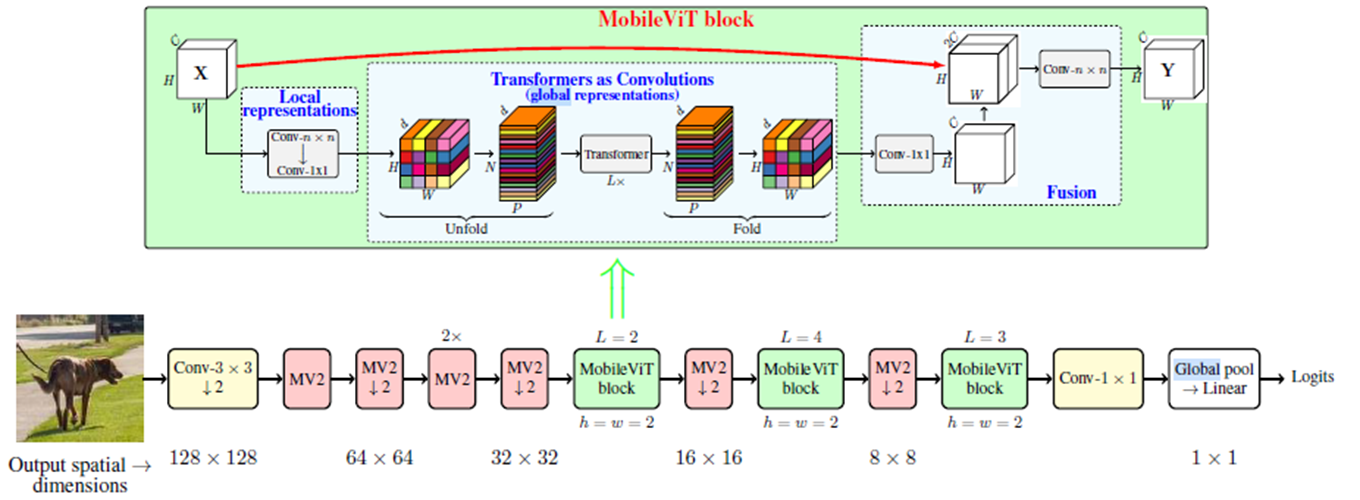
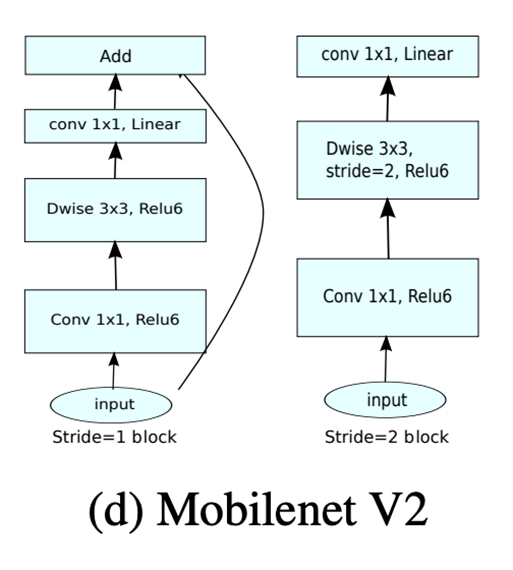

In [8]:
class InvertedResidual(nn.Module):
    """
    MobileNetv2 InvertedResidual block
    """
    def __init__(self, in_channels, out_channels, stride = 1, expand_ratio = 2, act_layer = nn.ReLU6):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        self.use_res_connect = self.stride == 1 and in_channels == out_channels
        hidden_dim = int(round(in_channels * expand_ratio))

        layers = []
        if expand_ratio != 1:
            layers.append(ConvNormAct(in_channels, hidden_dim, kernel_size = 1, activation_layer = None))

        # Depth-wise convolution
        layers.append(
            ConvNormAct(hidden_dim, hidden_dim, kernel_size = 3, stride = stride,
                        padding = 1, groups = hidden_dim, activation_layer = act_layer)
        )
        # Point-wise convolution
        layers.append(
            nn.Conv2d(hidden_dim, out_channels, kernel_size = 1, stride = 1, bias = False)
        )
        layers.append(nn.BatchNorm2d(out_channels))

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

In [9]:
class MobileViT(nn.Module):
    def __init__(self, img_size, features_list, d_list, transformer_depth, expansion, num_classes = 1000):
        super(MobileViT, self).__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = features_list[0], kernel_size = 3, stride = 2, padding = 1),
            InvertedResidual(in_channels = features_list[0], out_channels = features_list[1], stride = 1, expand_ratio = expansion),
        )

        self.stage1 = nn.Sequential(
            InvertedResidual(in_channels = features_list[1], out_channels = features_list[2], stride = 2, expand_ratio = expansion),
            InvertedResidual(in_channels = features_list[2], out_channels = features_list[2], stride = 1, expand_ratio = expansion),
            InvertedResidual(in_channels = features_list[2], out_channels = features_list[3], stride = 1, expand_ratio = expansion)
        )

        self.stage2 = nn.Sequential(
            InvertedResidual(in_channels = features_list[3], out_channels = features_list[4], stride = 2, expand_ratio = expansion),
            MobileVitBlock(in_channels = features_list[4], out_channels = features_list[5], d_model = d_list[0],
                           layers = transformer_depth[0], mlp_dim = d_list[0] * 2)
        )

        self.stage3 = nn.Sequential(
            InvertedResidual(in_channels = features_list[5], out_channels = features_list[6], stride = 2, expand_ratio = expansion),
            MobileVitBlock(in_channels = features_list[6], out_channels = features_list[7], d_model = d_list[1],
                           layers = transformer_depth[1], mlp_dim = d_list[1] * 4)
        )

        self.stage4 = nn.Sequential(
            InvertedResidual(in_channels = features_list[7], out_channels = features_list[8], stride = 2, expand_ratio = expansion),
            MobileVitBlock(in_channels = features_list[8], out_channels = features_list[9], d_model = d_list[2],
                           layers = transformer_depth[2], mlp_dim = d_list[2] * 4),
            nn.Conv2d(in_channels = features_list[9], out_channels = features_list[10], kernel_size = 1, stride = 1, padding = 0)
        )

        self.avgpool = nn.AvgPool2d(kernel_size = img_size // 32)
        self.fc = nn.Linear(features_list[10], num_classes)


    def forward(self, x):
        # Stem
        x = self.stem(x)
        # Body
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        # Head
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


## MobileViT Model

In [10]:
model_cfg = {
    "xxs":{
        "features": [16, 16, 24, 24, 48, 48, 64, 64, 80, 80, 320],
        "d": [64, 80, 96],
        "expansion_ratio": 2,
        "layers": [2, 4, 3]
    },
    "xs":{
        "features": [16, 32, 48, 48, 64, 64, 80, 80, 96, 96, 384],
        "d": [96, 120, 144],
        "expansion_ratio": 4,
        "layers": [2, 4, 3]
    },
    "s":{
        "features": [16, 32, 64, 64, 96, 96, 128, 128, 160, 160, 640],
        "d": [144, 192, 240],
        "expansion_ratio": 4,
        "layers": [2, 4, 3]
    },
}

def MobileViT_XXS(img_size = 256, num_classes = 1000):
    cfg_xxs = model_cfg["xxs"]
    model_xxs = MobileViT(img_size, cfg_xxs["features"], cfg_xxs["d"], cfg_xxs["layers"], cfg_xxs["expansion_ratio"], num_classes)
    return model_xxs

def MobileViT_XS(img_size = 256, num_classes = 1000):
    cfg_xs = model_cfg["xs"]
    model_xs = MobileViT(img_size, cfg_xs["features"], cfg_xs["d"], cfg_xs["layers"], cfg_xs["expansion_ratio"], num_classes)
    return model_xs

def MobileViT_S(img_size = 256, num_classes = 1000):
    cfg_s = model_cfg["s"]
    model_s = MobileViT(img_size, cfg_s["features"], cfg_s["d"], cfg_s["layers"], cfg_s["expansion_ratio"], num_classes)
    return model_s


if __name__ == "__main__":
    img = torch.randn(1, 3, 256, 256)

    cfg_xxs = model_cfg["xxs"]
    model_xxs = MobileViT(256, cfg_xxs["features"], cfg_xxs["d"], cfg_xxs["layers"], cfg_xxs["expansion_ratio"])

    cfg_xs = model_cfg["xs"]
    model_xs = MobileViT(256, cfg_xs["features"], cfg_xs["d"], cfg_xs["layers"], cfg_xs["expansion_ratio"])

    cfg_s = model_cfg["s"]
    model_s = MobileViT(256, cfg_s["features"], cfg_s["d"], cfg_s["layers"], cfg_s["expansion_ratio"])

    print(model_s)

    # XXS: 1.3M 、 XS: 2.3M 、 S: 5.6M
    print("XXS params: ", sum(p.numel() for p in model_xxs.parameters()))
    print(" XS params: ", sum(p.numel() for p in model_xs.parameters()))
    print("  S params: ", sum(p.numel() for p in model_s.parameters()))

MobileViT(
  (stem): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormAct(
          (conv): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm_layer): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): ConvNormAct(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (norm_layer): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): ReLU6()
        )
        (2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (stage1): Sequential(
    (0): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormAct(
          (conv): Conv2d(32, 128, kernel_size=(1, 1), strid

: 

## 학습을 위한 Main 함수

In [ ]:
import sys
import os
import shutil
import utils

import torch
import torch.nn as nn
from torchvision import transforms as T
import torchvision.datasets as datasets
from tqdm import tqdm
import wandb

def save_checkpoint(state, is_best, filename = 'checkpoint.pth.tar'): 
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


def train_epoch(epoch, net, train_loader, val_loader , criterion, optimizer, scheduler, device):
    global best_acc1
    train_loss = utils.AverageMeter("Epoch losses", ":.4e")
    train_acc1 = utils.AverageMeter("Train Acc@1", ":6.2f")
    train_acc5 = utils.AverageMeter("Train Acc@5", ":6.2f")
    progress_train = utils.ProgressMeter(
        num_batches = len(val_loader),
        meters = [train_loss, train_acc1, train_acc5],
        prefix = 'Epoch: {} '.format(epoch + 1),
        batch_info = " Iter"
    )
    net.train()

    for it, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        acc1, acc5 = utils.accuracy(outputs, targets, topk = (1, 5))

        train_loss.update(loss.item(), inputs.size(0))
        train_acc1.update(acc1.item(), inputs.size(0))
        train_acc5.update(acc5.item(), inputs.size(0))
        if it % print_freq == 0:
            progress_train.display(it)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Log on Wandb
        wandb.log({
            "Loss/train" : train_loss.avg,
            "Acc@1/train" : train_acc1.avg,
            "Acc@5/train" : train_acc5.avg,
        })
    scheduler.step()

    # Validation model
    val_loss = utils.AverageMeter("Val losses", ":.4e")
    val_acc1 = utils.AverageMeter("Val Acc@1", ":6.2f")
    val_acc5 = utils.AverageMeter("Val Acc@5", ":6.2f")
    progress_val = utils.ProgressMeter(
        num_batches = len(val_loader),
        meters = [val_loss, val_acc1, val_acc5],
        prefix = 'Epoch: {} '.format(epoch + 1),
        batch_info = " Iter"
    )
    net.eval()

    for it, (inputs, targets) in enumerate(val_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        with torch.no_grad():
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            acc1, acc5 = utils.accuracy(outputs, targets, topk=(1, 5))
        val_loss.update(loss.item(), inputs.size(0))
        val_acc1.update(acc1.item(), inputs.size(0))
        val_acc5.update(acc5.item(), inputs.size(0))
        acc1 = val_acc1.avg

        if it % print_freq == 0:
            progress_val.display(it)

        # Log on Wandb
        wandb.log({
            "Loss/val" : val_loss.avg,
            "Acc@1/val" : val_acc1.avg,
            "Acc@5/val" : val_acc5.avg
        })

    is_best = acc1 > best_acc1
    best_acc1 = max(acc1, best_acc1)
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': net.state_dict(),
        'best_acc1': best_acc1,
        'optimizer' : optimizer.state_dict(),
    }, is_best)
    return val_loss.avg, val_acc1.avg, val_acc5.avg


if __name__ == "__main__":
    # Default values instead of argparse
    best_acc1 = 0.0
    data_dir = 'C:/Users/kimin/imageNet-1k/'
    gpu_device = 2
    batch_size = 256
    epochs = 90
    num_class = 1000
    learning_rate = 0.05
    weight_decay = 5e-5
    print_freq = 10

    # autotune cudnn kernel choice
    torch.backends.cudnn.benchmark = True

    # Create folder to save model
    WEIGHTS_PATH = "./weights"
    if not os.path.exists(WEIGHTS_PATH):
        os.makedirs(WEIGHTS_PATH)

    # Set device
    os.environ["CUDA_VISIBLE_DEVICES"] = '1,2'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data loading
    traindir = os.path.join(data_dir, 'train')
    valdir = os.path.join(data_dir, 'val_sorted')
    normalize = T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

    train_dataset = datasets.ImageFolder(
        traindir,
        T.Compose([
            T.RandomResizedCrop(256),
            T.RandomHorizontalFlip(),
            T.ToTensor(),
            normalize,
    ]))
    val_dataset = datasets.ImageFolder(
        valdir,
        T.Compose([
            T.Resize(256),
            T.ToTensor(),
            normalize,
    ]))

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size = batch_size, shuffle = True,
        num_workers = 4,  pin_memory = True
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size = batch_size, shuffle = False,
        num_workers = 4, pin_memory = True
    )

    # Create model
    net = MobileViT_S()
    net = torch.nn.DataParallel(net).to(device)

    # Set loss function and optimizer
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.SGD(net.parameters(), learning_rate,
                                momentum = 0.9,
                                weight_decay = weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

    # Using wandb for logging
    wandb.init()
    wandb.config.update({
        "batch_size": batch_size,
        "epochs": epochs,
        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        "num_class": num_class
    })
    wandb.watch(net)

    # Train the model
    for epoch in tqdm(range(epochs)):
        loss, acc1, acc5 = train_epoch(epoch, net, train_loader,
            val_loader, criterion, optimizer, scheduler, device
        )
        print(f"Epoch {epoch} ->  Acc@1: {acc1}, Acc@5: {acc5}")

    print("Training is done")
